In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-bert/dataset_sentiment_updated_3labels.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_EmotionMoodtags_Dataset.csv
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-V3.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-Emotion_Mood_Tags-V3.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_dataset_main.csv
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-Sentiment_Polarities_3_Label-V3.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-Sentiment_Polarities_2_Label-V3 (Neutral Omitted).xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-V2.xlsx
/kaggle/input/data-sentiment-final/dataset_sentiment_updated.xlsx


In [91]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [92]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [94]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET

In [95]:
df=pd.read_excel("/kaggle/input/dataset-bert/dataset_sentiment_updated_3labels.xlsx")
df.shape

(10280, 3)

In [96]:
df.head()

,Informal Text,Expanded Meaning,Sentiment
0,"omg, JEE prep is killing me rn",oh my god joint entrance examination preparati...,negative
1,u up 4 a break b4 UPSC revision?,are you up for a break before union public ser...,neutral
2,"ttyl, finishing da CAT mock",talk to you later finishing the common admissi...,neutral
3,"nah, dat GATE paper was brutal af",no that graduate aptitude test in engineering ...,negative
4,sup? u done w/ ur IIT assignment?,whats up are you done with your indian institu...,neutral


In [97]:
# df.drop(columns=['Sentiment.1'],inplace=True)

## PREPROCESSING

In [98]:
df=df.drop('Expanded Meaning',axis=1)

In [99]:
df.shape

(10280, 2)

In [100]:
df = df.rename(columns={'Informal Text': 'tweet'})

In [101]:
df = df.rename(columns={'Sentiment': 'class'})

In [102]:
df['class'] = df['class'].str.lower()
sentiment_counts = df['class'].value_counts()
sentiment_counts

class
negative    4224
neutral     3351
positive    2705
Name: count, dtype: int64

In [103]:
#df = df[df['class'] != "neutral"]  ###droping neutral columns

In [104]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])
encoded_labels = label_encoder.transform(df['class'])
df['class'] = encoded_labels

In [105]:
df.head()

,tweet,class
0,"omg, JEE prep is killing me rn",0
1,u up 4 a break b4 UPSC revision?,1
2,"ttyl, finishing da CAT mock",1
3,"nah, dat GATE paper was brutal af",0
4,sup? u done w/ ur IIT assignment?,1


In [106]:
df.isnull().sum()

tweet    2
class    0
dtype: int64

In [107]:
df=df.fillna('')

In [108]:
df.head()

,tweet,class
0,"omg, JEE prep is killing me rn",0
1,u up 4 a break b4 UPSC revision?,1
2,"ttyl, finishing da CAT mock",1
3,"nah, dat GATE paper was brutal af",0
4,sup? u done w/ ur IIT assignment?,1


In [109]:
import re
from bs4 import BeautifulSoup

def text_cleaning(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")    ###removing html tages
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())      ##removing text within square brackets
    pattern = r"[^a-zA-Z0-9\s,']"                  # Removing unwanted characters
    text = re.sub(pattern, '', text)
    url_pattern = r'http\S+|www\S+'            ###removing urls
    text = re.sub(url_pattern, '', text)
    return text

In [110]:
df['tweet'] = df['tweet'].apply(text_cleaning).tolist()

In [111]:
df.head(10)

,tweet,class
0,"omg, JEE prep is killing me rn",0
1,u up 4 a break b4 UPSC revision,1
2,"ttyl, finishing da CAT mock",1
3,"nah, dat GATE paper was brutal af",0
4,sup u done w ur IIT assignment,1
5,"fyi, da UPSC date changed again",1
6,"rn, stuck on a prob from NEET guide",0
7,"gtg, hv to prep 4 da JEE mock tmr",1
8,dat prof's lectures 4 MBA prep r tough,1
9,"nah, can't chill 2day, gotta focus on JEE mains",0


In [112]:
lens=[len(i.split()) for i in df['tweet']]

(array([5.570e+02, 3.705e+03, 3.198e+03, 1.312e+03, 6.970e+02, 5.150e+02,
        2.550e+02, 3.500e+01, 5.000e+00, 1.000e+00]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

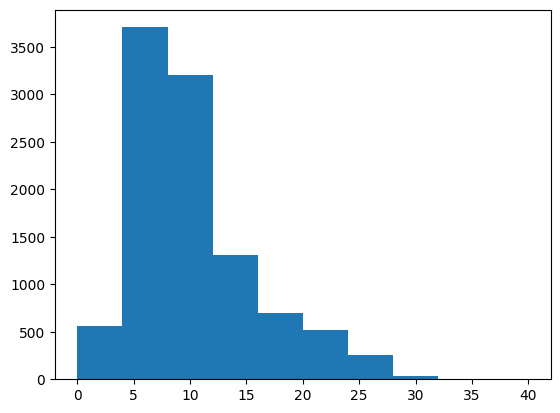

In [113]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [114]:
import torch
import torch.nn as nn

import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModel, AdamW, get_linear_schedule_with_warmup

In [115]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['class'], 
                                                                    random_state=2021, 
                                                                    test_size=0.1, 
                                                                    stratify=df['class'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [116]:
bert = AutoModel.from_pretrained('bert-base-uncased')

In [117]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

(array([4.920e+02, 3.341e+03, 2.879e+03, 1.187e+03, 6.240e+02, 4.580e+02,
        2.350e+02, 3.000e+01, 5.000e+00, 1.000e+00]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

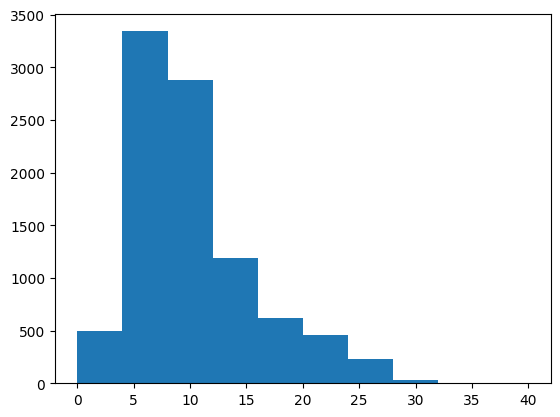

In [118]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [119]:
import pandas as pd

sequence_lengths = df['tweet'].apply(lambda x: len(x.split()))
print(sequence_lengths.describe())


count    10280.000000
mean         9.766148
std          5.433945
min          0.000000
25%          6.000000
50%          8.000000
75%         12.000000
max         40.000000
Name: tweet, dtype: float64


In [120]:
pad_len = 128

## ENCODING

In [121]:
# tokenizing and encoding sequences 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

In [122]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_token_type_ids = torch.tensor(tokens_train["token_type_ids"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_token_type_ids = torch.tensor(tokens_val["token_type_ids"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_token_type_ids = torch.tensor(tokens_test["token_type_ids"])
test_y = torch.tensor(test_labels.tolist())

In [123]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64  ##batch size can be adjusted or modified
train_data = TensorDataset(train_seq, train_mask, train_token_type_ids, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_token_type_ids, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [124]:
# for param in bert.parameters():
#     param.requires_grad = False

In [125]:
for name, param in bert.named_parameters():
    if "layer.11" in name or "layer.10" in name:  # Fine-tune last two layers
        param.requires_grad = True
    else:
        param.requires_grad = False

# MODEL

In [126]:
import torch.nn as nn

# ##model building
# # class SentimentClassifier(nn.Module):
     
# #     def __init__(self, n_classes):
# #         super(SentimentClassifier, self).__init__()
# #         self.bert = BertModel.from_pretrained(MODEL_NAME)
# #         self.drop = nn.Dropout(p=0.1)
# #         self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
# #     # Forward propagaion
# #     def forward(self, input_ids, attention_mask, token_type_ids):
# #         _, pooled_output = self.bert(
# #           input_ids=input_ids,
# #           attention_mask=attention_mask,
# #             token_type_ids=token_type_ids
# #         ) 
# #         output = self.drop(pooled_output)  ##drop out layer
# #         return self.out(output)

    
class BERT_architecture(nn.Module):

    def __init__(self, bert):
        super(BERT_architecture, self).__init__()
        self.bert = bert
        
        self.dropout = nn.Dropout(0.3)  # Increased dropout for regularization
        self.layer_norm = nn.LayerNorm(768)  # Layer normalization
        
        self.fc1 = nn.Linear(768, 256)  # Dense layer
        self.fc2 = nn.Linear(256, 3)  # Output layer with 3 classes
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask, token_type_ids):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        x = self.layer_norm(cls_hs)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [127]:
model = BERT_architecture(bert)

In [128]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
test_token_type_ids = test_token_type_ids.to(device)
model.to(device)

BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [129]:
from transformers import AdamW
# optimizer = AdamW(model.parameters(),lr = 1e-3)  ## learning rate needs to be adjusted.
# optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.02)

In [130]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn

# Compute the class weights for three classes
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_labels),
                                     y=train_labels)
print("Class weights are {} for {}".format(class_weights, np.unique(train_labels)))

Class weights are [0.81115203 1.02254642 1.26705012] for [0 1 2]


In [131]:
pd.value_counts(train_labels)

class
0    3802
1    3016
2    2434
Name: count, dtype: int64

In [132]:
# weights = torch.tensor(class_weights, dtype=torch.float)

# weights = weights.to(device)
# cross_entropy = nn.CrossEntropyLoss()

epochs = 30 ##increase the no of epochs for better accuracy 


## HYPERPARAMS SETUP

In [133]:
# total_steps = len(train_dataloader) * epochs

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# # Loss function
# weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [134]:
import torch
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * epochs

# Learning Rate Scheduler: Linear decay with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

# Weighted Cross-Entropy Loss (Handles class imbalance)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [135]:
from torch.cuda.amp import GradScaler, autocast

## EARLY STOPPING SETUP

In [136]:
class EarlyStopping:
    def __init__(self, patience, delta=0):  # Increased patience
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, valid_loss):
        if valid_loss < self.best_loss - self.delta:
            self.best_loss = valid_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [137]:
early_stopping = EarlyStopping(patience=3) #prev was 3

In [138]:
# Gradient Scaler
scaler = GradScaler()

## FUNCTIONS

In [139]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(train_dataloader, 0):
        batch = [r.to(device) for r in batch]
        sent_id, mask, token_type_ids, labels = batch

        optimizer.zero_grad()

        with autocast():
            preds = model(sent_id, mask, token_type_ids)
            loss = cross_entropy(preds, labels)
        
        # Accumulate the loss
        total_loss += loss.item()

        # Perform backward pass with mixed precision
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels

In [140]:
# def train():
#     model.train()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(train_dataloader, 0):
#         batch = [r.to(device) for r in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         model.zero_grad()
#         preds = model(sent_id, mask, token_type_ids)
#         loss = cross_entropy(preds, labels)
#         total_loss = total_loss + loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()

#         preds = preds.detach().cpu().numpy()
#         total_preds.append(preds)
#         total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(train_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels

In [141]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, token_type_ids, labels = batch

        with torch.no_grad(), autocast():
            preds = model(sent_id, mask, token_type_ids)
            loss = cross_entropy(preds, labels)
        
        total_loss += loss.item()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels

In [142]:
# def evaluate():
#     model.eval()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(val_dataloader):
#         batch = [t.to(device) for t in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         with torch.no_grad():
#             preds = model(sent_id, mask, token_type_ids)
#             loss = cross_entropy(preds, labels)
#             total_loss = total_loss + loss.item()
#             preds = preds.detach().cpu().numpy()
#             total_preds.append(preds)
#             total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(val_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels


In [143]:
def calculate_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
    return accuracy

In [144]:
# def train():
#     model.train()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(train_dataloader, 0):
#         if step % 50 == 0 and not step == 0:
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

# #         sent_id = batch[:,0].to(device, dtype = torch.long)
# #         mask = data[:,1].to(device, dtype = torch.long)
# #         token_type_ids = data[:,2].to(device, dtype = torch.long)
# #         labels = data[:,3].to(device, dtype = torch.float)
        
# #         token_type_ids = batch['token_type_ids'].to(device)
#         batch = [r.to(device) for r in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         model.zero_grad()
#         preds = model(sent_id, mask, token_type_ids)
#         loss = cross_entropy(preds, labels)
#         total_loss = total_loss + loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()

#         preds = preds.detach().cpu().numpy()
#         total_preds.append(preds)
#         total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(train_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels

# def evaluate():
#     print("\nEvaluating after the test: ")
#     model.eval()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(val_dataloader):
#         if step % 50 == 0 and not step == 0:
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            
# #         sent_id = batch[:,0].to(device, dtype = torch.long)
# #         mask = data[:,1].to(device, dtype = torch.long)
# #         token_type_ids = data[:,2].to(device, dtype = torch.long)
# #         labels = data[:,3].to(device, dtype = torch.float)

# #         token_type_ids = batch['token_type_ids'].to(device)
#         batch = [t.to(device) for t in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         with torch.no_grad():
#             preds = model(sent_id, mask, token_type_ids)
#             loss = cross_entropy(preds, labels)
#             total_loss = total_loss + loss.item()
#             preds = preds.detach().cpu().numpy()
#             total_preds.append(preds)
#             total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(val_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels

# def calculate_accuracy(preds, labels):

#     preds_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
#     return accuracy


In [145]:
# best_valid_loss = float('inf')
# train_losses = []
# valid_losses = []
# train_accuracies = []
# valid_accuracies = []

# for epoch in range(epochs):
#     print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
#     train_loss, train_preds, train_labels = train()
#     valid_loss, valid_preds, valid_labels = evaluate()
#     train_accuracy = calculate_accuracy(train_preds, train_labels)
#     valid_accuracy = calculate_accuracy(valid_preds, valid_labels)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'saved_weights.pt')
    
#     train_losses.append(train_loss)
#     valid_losses.append(valid_loss)
#     train_accuracies.append(train_accuracy)
#     valid_accuracies.append(valid_accuracy)
    
#     print('\nTraining Loss: {}'.format(train_loss))
#     print('Validation Loss: {}'.format(valid_loss))
#     print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
#     print('Validation Accuracy: {:.2f}%'.format(valid_accuracy * 100))


In [146]:
from torch.nn.functional import cross_entropy

In [147]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Initialize best validation loss and lists for storing logs
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
learning_rates = []  # Store learning rate per epoch

epochs = 30  # Change as needed

# Training loop
for epoch in range(epochs):
    print(f"\n Epoch {epoch+1}/{epochs}")

    # Train and validate
    train_loss, train_preds, train_labels = train()
    valid_loss, valid_preds, valid_labels = evaluate()

    # Compute accuracies
    train_accuracy = calculate_accuracy(train_preds, train_labels)
    valid_accuracy = calculate_accuracy(valid_preds, valid_labels)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)  # Store learning rate

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "saved_weights.pt")

    # Store metrics for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Early stopping
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    #Print metrics
    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))
    print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
    print('Validation Accuracy: {:.2f}%'.format(valid_accuracy * 100))
    print(f"Learning Rate: {current_lr:.6f}")



 Epoch 1/30

Training Loss: 1.0966610316572518
Validation Loss: 1.0541184610790677
Training Accuracy: 36.69%
Validation Accuracy: 49.81%
Learning Rate: 0.000007

 Epoch 2/30

Training Loss: 0.9612104859845392
Validation Loss: 0.7370522419611613
Training Accuracy: 54.68%
Validation Accuracy: 66.34%
Learning Rate: 0.000013

 Epoch 3/30

Training Loss: 0.7629133693103133
Validation Loss: 0.6109829660918977
Training Accuracy: 67.62%
Validation Accuracy: 72.18%
Learning Rate: 0.000020

 Epoch 4/30

Training Loss: 0.6686397838181463
Validation Loss: 0.5511702961391873
Training Accuracy: 72.21%
Validation Accuracy: 76.65%
Learning Rate: 0.000019

 Epoch 5/30

Training Loss: 0.5984941766179841
Validation Loss: 0.5397057003445096
Training Accuracy: 75.43%
Validation Accuracy: 75.10%
Learning Rate: 0.000019

 Epoch 6/30

Training Loss: 0.5498995501419593
Validation Loss: 0.543383495675193
Training Accuracy: 77.35%
Validation Accuracy: 75.68%
Learning Rate: 0.000018

 Epoch 7/30

Training Loss: 

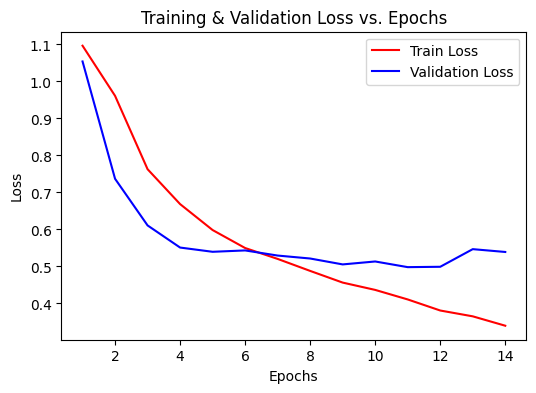

In [148]:
# 📌 Plot Training & Validation Loss vs. Epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='red')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs. Epochs")
plt.savefig("/kaggle/working/fig1.png")
plt.legend()
plt.show()


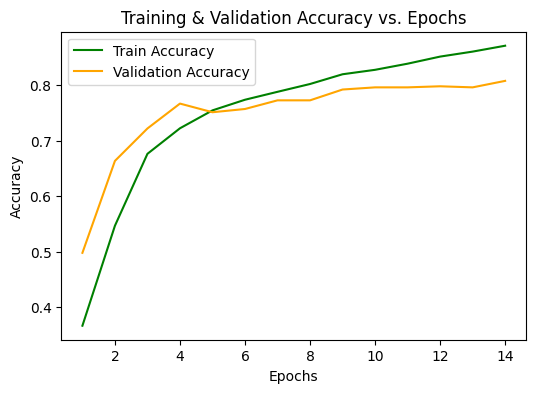

In [149]:
# 📌 Plot Training & Validation Accuracy vs. Epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='green')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy vs. Epochs")
plt.legend()
plt.savefig("/kaggle/working/fig2.png")
plt.show()

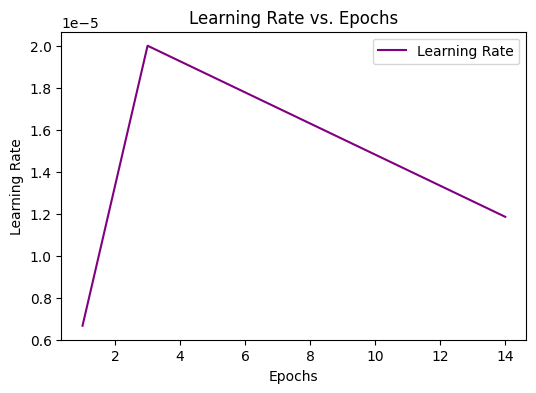

In [150]:
# 📌 Plot Learning Rate vs. Epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, label="Learning Rate", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs. Epochs")
plt.savefig("/kaggle/working/fig3.png")
plt.legend()
plt.show()

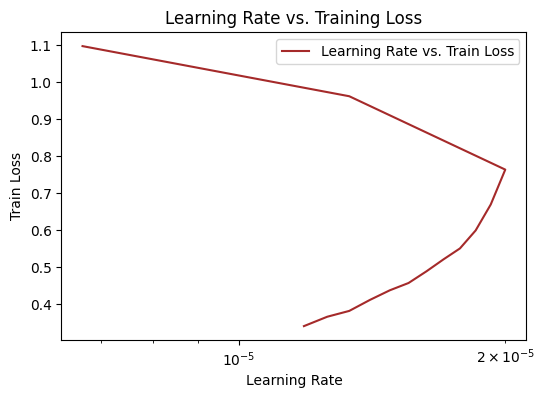

In [151]:
# 📌 Plot Learning Rate vs. Training Loss
plt.figure(figsize=(6, 4))
plt.plot(learning_rates, train_losses, label="Learning Rate vs. Train Loss", color='brown')
plt.xlabel("Learning Rate")
plt.ylabel("Train Loss")
plt.xscale("log")  # Log scale for better visualization
plt.title("Learning Rate vs. Training Loss")
plt.savefig("/kaggle/working/fig4.png")
plt.legend()
plt.show()

# CLASSIFICATION REPORT

In [152]:
from sklearn.metrics import classification_report
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device), test_token_type_ids.to(device))
  preds = preds.detach().cpu().numpy()
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       211
           1       0.75      0.71      0.73       168
           2       0.79      0.76      0.77       135

    accuracy                           0.78       514
   macro avg       0.78      0.77      0.77       514
weighted avg       0.78      0.78      0.78       514



In [153]:
def predict_user_input(input_text, model, tokenizer, device):
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_seq_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt',
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, token_type_ids)
        preds = torch.argmax(outputs, dim=1)
    
    return preds.item()
max_seq_len=128
input_text = "I been told you that yo folks dont care about you . Im starving and my dad deadass didnt make me a plate"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
elif (predicted_class==1):
    print('Predicted sentiment: Neutral')
else:
    print('Predicted sentiment: Positive')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Predicted sentiment: Negative


In [154]:
input_text = "what a badass character Arthur is, rckstr is the bst"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
elif (predicted_class==1):
    print('Predicted sentiment: Neutral')
else:
    print('Predicted sentiment: Positive')

Predicted sentiment: Negative


In [155]:
input_text = "brb! hv to study for tmrw"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
elif (predicted_class==1):
    print('Predicted sentiment: Neutral')
else:
    print('Predicted sentiment: Positive')

Predicted sentiment: Neutral


In [156]:
input_text = "lesss go! champs!!"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
elif (predicted_class==1):
    print('Predicted sentiment: Neutral')
else:
    print('Predicted sentiment: Positive')

Predicted sentiment: Neutral


In [158]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
# # secret_value_0 = user_secrets.get_secret("HF_READ_TOKEN")
secret_value_1 = user_secrets.get_secret("HF_READ_WRITE_TOKEN")

In [159]:
from huggingface_hub import login

# # Replace 'your_hf_token' with your actual Hugging Face API token
login(token=user_secrets.get_secret("HF_READ_WRITE_TOKEN"))

In [160]:
!huggingface-cli upload tachygraphy-microtrext-norm-org/BERT-LV1-SentimentPolarities /kaggle/working/saved_weights.pt

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
saved_weights.pt: 100%|██████████████████████| 439M/439M [00:08<00:00, 53.4MB/s]
https://huggingface.co/tachygraphy-microtrext-norm-org/BERT-LV1-SentimentPolarities/blob/main/saved_weights.pt
